<a href="https://colab.research.google.com/github/zfukuoka/Training-KikaiGakusyuZukan/blob/master/Chap2_02_RidgeRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第２章  教師あり学習

## 02 正則化

ポイント

* 正則化は過学習を防ぐための手法の一つで線形回帰のアルゴリズムと共に利用
* テキストでは $y = sin(2 \pi x)$ に乱数を加えて生成したデータを元に学習に用いたデータと検証データを分けたうえで、学習誤差と検証誤差をまとめた例で説明
  * 線形回帰の次元を増やしていくと学習誤差は小さくなる一方、検証誤差は大きくなる結果

| 次数 | 学習誤差 | 検証誤差 |
| :--- | :---: | :---: |
| 1 | 0.412 | 0.618 |
| 2 | 0.176 | 0.193 |
| 3 | 0.081 | 0.492 |
|   |       |       |
| 6 | 0.024 | 3.472 | 

* 上記の事例に正則化したら、下記のようになったという結果

| 次数 | 学習誤差 | 検証誤差 |
| :--- | :---: | :---: |
| 1 | 0.412 | 0.612 |
| 2 | 0.372 | 0.532 |
| 3 | 0.301 | 0.394 |
|   |       |       |
| 6 | 0.159 | 0.331 |

* 複雑なモデル（次数が高いモデル）が過学習する様子と過学習を防げる様子は上記の事例で確認
  * 過学習の原因として、学習パラメータ $w1$ が極端に大きい（または小さい）値を取ることがある

| 次数 | $w0$ | $w1$ | $w2$ | $w3$ | $w4$ | $w5$ | $w6$ |
| :--- | ---: | ---: | ---: | ---: | ---: | ---: | ---: |
| 1 | -0.007 | -0.217 |        |        | | | |
| 2 |  0.978 | -5.222 |  4.204 |        | | | |
| 3 |  0.281 |  4.927 |-17.639 | 12.157 | | | |
| 6 |  1.080 |-26.324 |287.431 |-1024.141|1611.144|-1147.946|308.643|

* 上記の事例に正則化したら、下記のようになったという結果

| 次数 | $w0$ | $w1$ | $w2$ | $w3$ | $w4$ | $w5$ | $w6$ |
| :--- | ---: | ---: | ---: | ---: | ---: | ---: | ---: |
| 1 | -0.055 | -0.149 |        |        | | | |
| 2 | -0.066 | -0.493 |  0.421 |        | | | |
| 3 | -0.001 | -0.716 | -0.042 |  0.670 | | | |
| 6 |  0.191 | -0.751 | -0.497 | -0.182|  0.109 |  0.370 |  0.607|

* 正則化で学習パラメータを抑えることができるのかRidge回帰の誤差関数（2次関数の場合）
  * 右辺の第1項は線形回帰の損失関数
  * 右辺の第2講は罰則項（または正規化項）と呼ばれるもので、学習パラメータの2乗和
    * 切片である $w0$ は罰則項に含まないのが一般的
    * $\alpha $ ( >= 0) は正規化の強さをコントロールするパラメータで$\alpha$ が大きいほど学習パラメータが抑えられ、$\alpha$ が小さいほど学習データへの当てはまりが強くなる
  * Ridge回帰の損失関数 $R(w)$ を最小化するには...
    * 右辺の第1項だけに注目すると、学習データ $y$ との誤差を小さくするような任意の $w0$, $w1$, $w2$ を問題になる
    * しかし、右辺の第2項の罰則項は学習パラメータの2乗和になっているので、学習パラメータの絶対値が大きいと、損失関数全体が大きくなってしまう
      * 結局のところ罰則項は学習パラメータの絶対値が大きくなることに対して損失が大きくなるような罰則を与える役割を持っており、この役割で学習パラメータを抑えている

$$
R(w) = 
\sum_{i=1}^{n} 
  \Bigl( 
    y_i
    \bigl(
      w_0 + w_1 x_i + w_2 x_i^2
    \bigr)
  \Bigr)^2 + \alpha \bigl(
    w_1^2 + w_2^2
  \bigr)
$$


* サンプルコードのポイント
  * 前に sklearn.linear_model の中の LinearRegression クラスを用いて、線形回帰を試していたが、今回は正則化対応している Ridge クラス Ridge回帰を行う
    * 恐らく、Ridgeクラスのコンストラクタに渡しているのが、alphaすなわち正則化の強さを設定している
    * sklearn.preprocessing の [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) クラスは線形回帰でなく、多項式を用いるのに利用しているらしいが、この使い方は **もう少し調査が必要**
      * Ridge回帰の学習データと検証データの両方に PolynomiaFeatures の fit_transform() を介して出力したデータを用いていることから何かしらの元のデータに何かを加えているものと思われる
      * なお、 np.random.uniform() は引数の間の乱数生成なので、fit_transform()の引数で渡しているのはただの乱数
    * Ridgeクラスの使い方は、LinearRegressionクラスと同じで空のモデルを生成し、fit()で学習モデルを作成し、predict()で学習モデルを用いた予測を行っている

In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

train_size = 20
test_size = 12
train_X = np.random.uniform(low=0.0, high=1.2, size=train_size)
test_X = np.random.uniform(low=0.1, high=1.3, size=test_size)
train_y = np.sin(train_X * 2 * np.pi) + np.random.normal(0.0, 0.2, train_size)
test_y = np.sin(test_X * 2 * np.pi) + np.random.normal(0.0, 0.2, test_size)

poly = PolynomialFeatures(6) #次数は6
train_poly_X = poly.fit_transform(train_X.reshape(train_size, 1))
test_poly_X = poly.fit_transform(test_X.reshape(test_size, 1))

model = Ridge(alpha=1.0)
model.fit(train_poly_X, train_y)
train_pred_y = model.predict(train_poly_X)
test_pred_y = model.predict(test_poly_X)

print(mean_squared_error(train_pred_y, train_y))
print(mean_squared_error(test_pred_y, test_y))


0.20899796461433864
0.25035442446906714


[ 0.         -0.84187746 -0.76463379 -0.40821051 -0.00463911  0.3849205
  0.74985891]
0.7325330361685184
None
2.2395768753826957 5.210596240059123e-10 3.508039851680207 2.6063975808063655e-06
[[1.00000000e+00 7.98905327e-01 6.38249721e-01 5.09901102e-01
  4.07362707e-01 3.25444236e-01 2.59999134e-01]
 [1.00000000e+00 8.29965517e-01 6.88842760e-01 5.71715738e-01
  4.74504348e-01 3.93822247e-01 3.26858885e-01]
 [1.00000000e+00 4.20044955e-01 1.76437764e-01 7.41117925e-02
  3.11302845e-02 1.30761190e-02 5.49255779e-03]
 [1.00000000e+00 4.37002979e-01 1.90971604e-01 8.34551597e-02
  3.64701534e-02 1.59375657e-02 6.96476368e-03]
 [1.00000000e+00 1.14382872e+00 1.30834413e+00 1.49652159e+00
  1.71176437e+00 1.95796525e+00 2.23957688e+00]
 [1.00000000e+00 1.09264966e+00 1.19388327e+00 1.30449615e+00
  1.42535727e+00 1.55741614e+00 1.70171021e+00]
 [1.00000000e+00 2.26589329e-01 5.13427239e-02 1.16337134e-02
  2.63607530e-03 5.97306533e-04 1.35343286e-04]
 [1.00000000e+00 3.97690270e-01 1.5815

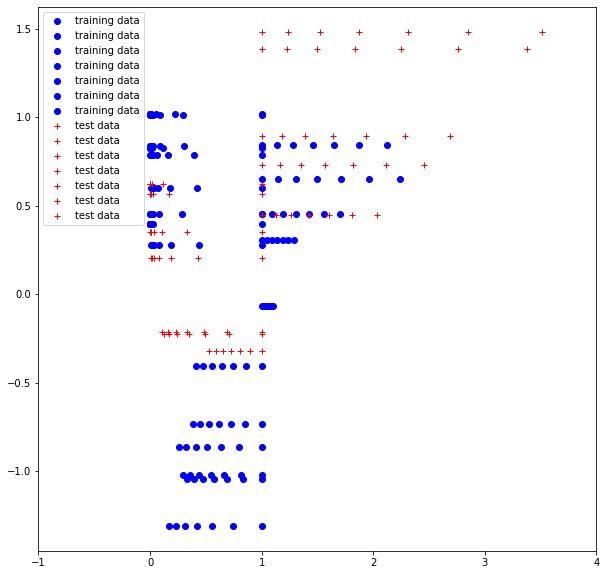

In [ ]:
print(model.coef_)
print(model.intercept_)
print(model.n_iter_)
print(train_poly_X.max(), train_poly_X.min(), test_poly_X.max(), test_poly_X.min())
print(train_poly_X)
print(train_pred_y)

# 下記はプロットしようとしたが、trainのデータが7つのデータの20セットと忘れているため、適切でない
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
axe = fig.add_subplot(111, xlim=(-1,4))
axe.plot(train_poly_X, train_y, "bo", label="training data")
axe.plot(test_poly_X, test_pred_y, "r+", label="test data")
#converged_X = [i / 10 for i in range(-10, 30)]
#converged_Y = [
#               model.coef_[1] * ((i/10)**1)
#               + model.coef_[2] * ((i/10)**2)
#               + model.coef_[3] * ((i/10)**3)
#               + model.coef_[4] * ((i/10)**4)
#               + model.coef_[5] + ((i/10)**5)
#               + model.coef_[6] + ((i/10)**6)
#               + model.intercept_ for i in range(-10, 30)]
#axe.plot(converged_X, converged_Y, "--", label="converged")
axe.legend()
